# Analysis for ORLR workshop, NeurIPS 2020

In [1]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
sys.path.append("../utils")
sys.path.append("../analysis/utils")


import numpy as np
import scipy.stats as stats
import pandas as pd

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import drawing_utils as drawing
import importlib
import scoring

### Load dataframes

In [11]:
#read in dataframes from each eventType
df_block = pd.read_csv('../results/csv/df_block.csv')
df_chat = pd.read_csv('../results/csv/df_chat.csv')
df_exit = pd.read_csv('../results/csv/df_exit.csv')
df_trial = pd.read_csv('../results/csv/df_trial.csv')

### Apply exclusion criteria

In [12]:
# How many dyads fulfill 75% Accuracy on 75% of trials
df75 = pd.DataFrame(df_trial.groupby(['gameid', 'trialNum'])['trialScore'].sum()>75).groupby(['gameid']).sum()
df75['trials'] = df75['trialScore']

#delete rows that aren't greater than 75% in 9 trials
df75 = df75[df75['trials']>=9]

print("Total dyads achieving 75% Accuracy on 75% of trials:",len(df75))

Total dyads achieving 75% Accuracy on 75% of trials: 49


In [13]:
includedGames = list(df75.reset_index().gameid)

In [14]:
# Exclude from analysis
df_block = df_block[df_block.gameid.isin(includedGames)]
df_chat = df_chat[df_chat.gameid.isin(includedGames)]
df_exit = df_exit[df_exit.gameid.isin(includedGames)]
df_trial = df_trial[df_trial.gameid.isin(includedGames)]

## Task performance

### Accuracy

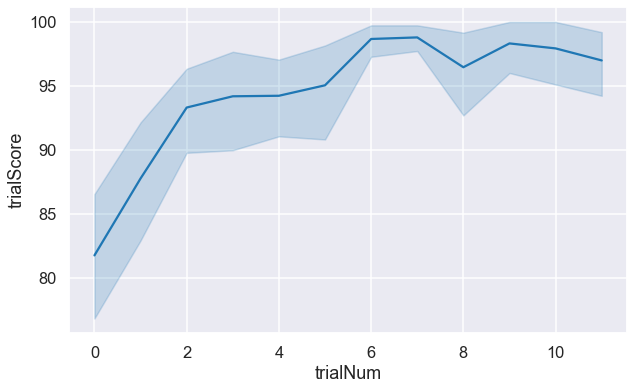

In [15]:
# accuracy across trials
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='x')
# sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='trialScore', hue='gameid')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

### Timing

In [ ]:
# # Wrangle timing dataframes

# # Find the latest time that a block was placed in each trial.
# # This signifies the end of a trial (i.e. upper bound on total trial time)
# df_trial_time = df_block[~df_block.practice].groupby(['gameid','trialNum'])\
#                 ['timeElapsedInTrial'].max().reset_index()
# df_trial_time = df_trial_time.rename(columns = {'timeElapsedInTrial':'time_final_block'})

# # Grab the duration of the Architect's turn
# chat_times = df_chat[~df_chat.practice].groupby(['gameid','trialNum'])\
# ['timeElapsedInTurn'].sum().reset_index()

# # total time to place blocks (by taking summing maximum block placement time for each turn)
# total_block_times = df_block[(~df_block.practice)].groupby(['gameid','trialNum','turnNum'])\
#                     ['timeElapsedInTurn'].max()\
#                     .groupby(['gameid','trialNum']).sum().reset_index()

# # # time from trial_start to final block placed in turn, summed across the trial
# df_trial_time['total_block_duration'] = total_block_times['timeElapsedInTurn'] 

# # time from trial_start to chat message sent, summed across the trial
# df_trial_time['total_chat_duration'] = chat_times['timeElapsedInTurn']

# # # sum of block placement and chat time in a trial
# df_trial_time['total_duration'] = df_trial_time['total_chat_duration'] + df_trial_time['total_block_duration']

# # # differnce between final block placement time and total chat plus block placement time.
# # # i.e. the total extra time in a trial, mainly consisting of time to press done button
# df_trial_time['diff'] = df_trial_time['time_final_block'] - df_trial_time['total_duration']

# # in addition, add a total_turn_duration- 
# #  the time between this turn start and the next turn start (or final block placement)
# #  as an estimate for when the Done button is pressed.
# # didn't have the data for this in pilot3- we are now saving turnStartTime

# # re-add trial info to trial df
# df_trial = df_trial.merge(df_trial_time, how='left', on=['gameid','trialNum'])

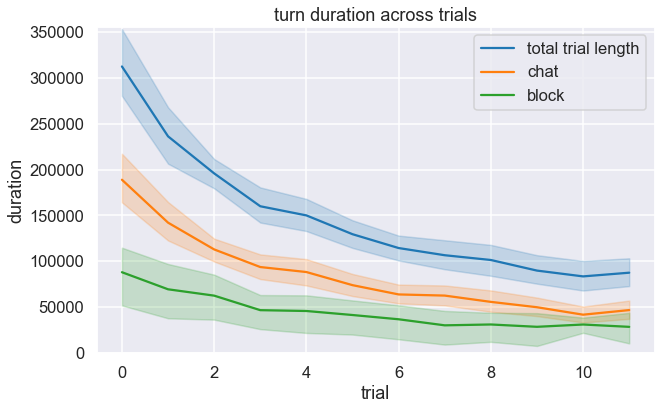

In [7]:
# total trial time across trials

g = plt.figure(figsize=(10,6))
ax1 = sns.lineplot(data=df_trial, x='trialNum', y='time_final_block', label='total trial length')
ax2 = sns.lineplot(data=df_trial, x='trialNum', y='total_chat_duration', label='chat')
ax3 = sns.lineplot(data=df_trial, x='trialNum', y='total_block_duration', label='block')

plt.ylabel('duration')
plt.xlabel('trial')
plt.ylim((0,355000))
plt.title('turn duration across trials')
plt.legend()

Text(0.5, 1.0, 'trial duration (final block placement time) across trials')

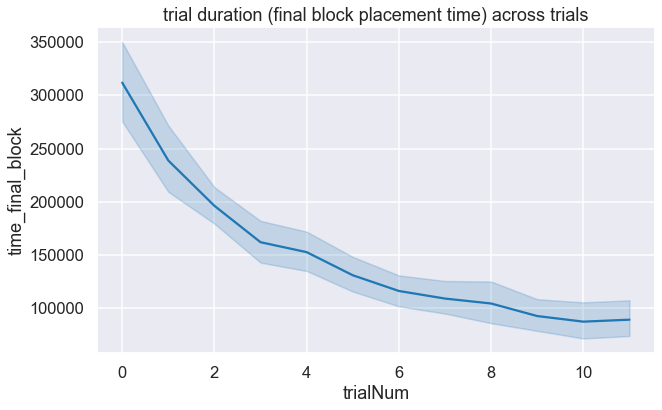

In [8]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.flagged], x='trialNum', y='time_final_block')
# plt.ylim((0,350000))
plt.title('trial duration (final block placement time) across trials')

Text(0.5, 1.0, 'total chat duration across trials')

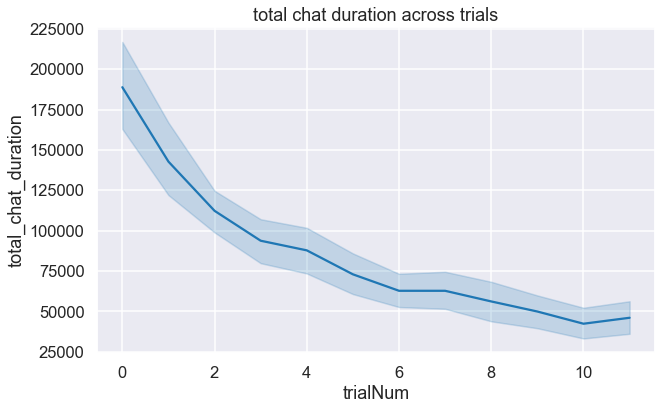

In [9]:
# total chat duration (architect turn-time) across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.flagged], x='trialNum', y='total_chat_duration')
# plt.ylim((0,350000))
plt.title('total chat duration across trials')

Text(0.5, 1.0, 'total block duration across trials')

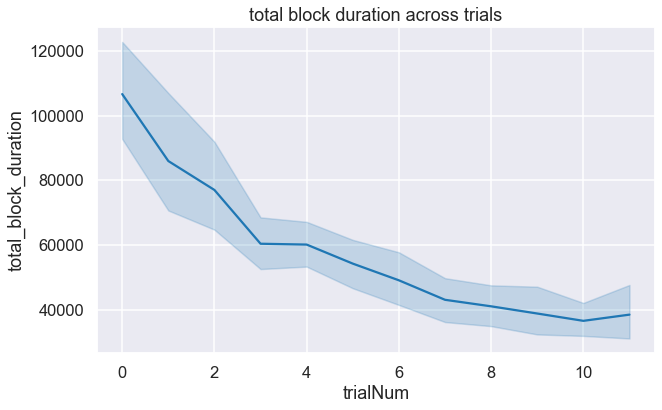

In [10]:
# total block placement duration (builder turn-time, not inluding no-block turns), across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.flagged], x='trialNum', y='total_block_duration')
# plt.ylim((0,350000))
plt.title('total block duration across trials')

Text(0.5, 1.0, 'difference between total block time and final block times')

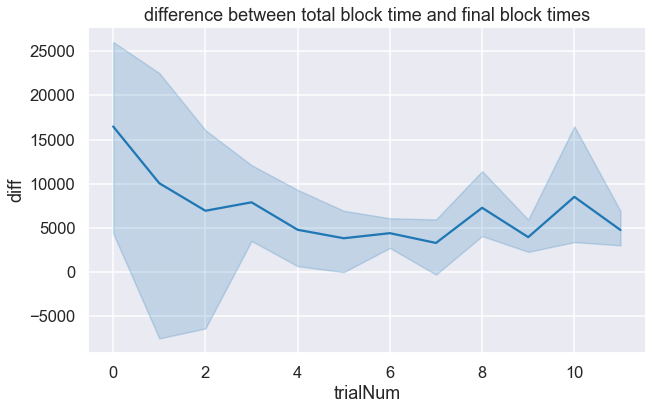

In [11]:
# total block placement duration (builder turn-time, not inluding no-block turns), across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.flagged], x='trialNum', y='diff')
# plt.ylim((0,350000))
plt.title('difference between total block time and final block times')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

## NLP

### Efficiency of instructions

#### Across trials

Text(0.5, 1.0, 'total words across trials')

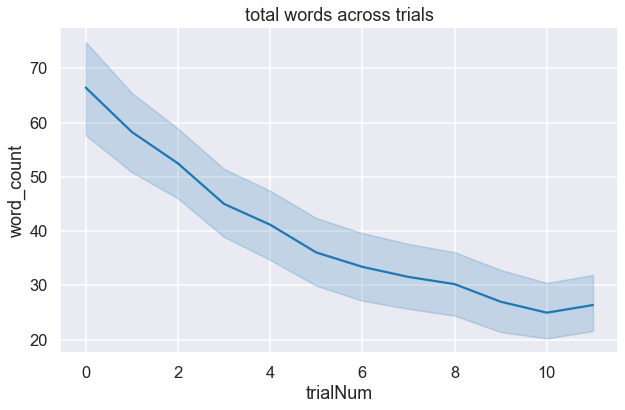

In [29]:
# word count across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='word_count')
#              , hue='gameid')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('total words across trials')

Text(0.5, 1.0, 'total characters across trials')

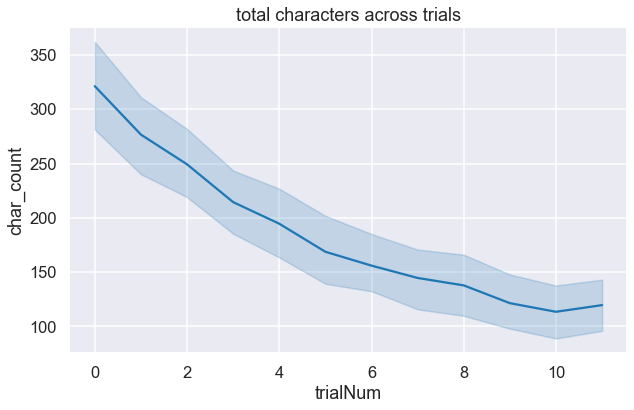

In [31]:
# char count across trials

plt.figure(figsize=(10,6))
sns.lineplot(data=df_trial[~df_trial.practice], x='trialNum', y='char_count')
             #, hue='gameid')
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('total characters across trials')

#### Across repetitions of scenes (sides of towers can switch)

In [8]:
rep_sums = df_chat[~df_chat.practice].groupby(['gameid','repNum']).sum().reset_index()
trial_counts = df_chat.groupby(['gameid','trialNum']).count().reset_index()

Text(0.5, 1.0, 'total words across reps')

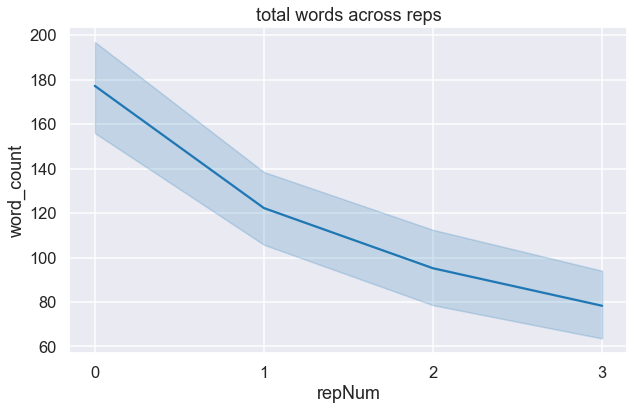

In [9]:
# word count across reps

plt.figure(figsize=(10,6))
sns.lineplot(data=rep_sums, x='repNum',y='word_count')
plt.title('total words across reps')

Text(0.5, 1.0, 'total characters across reps')

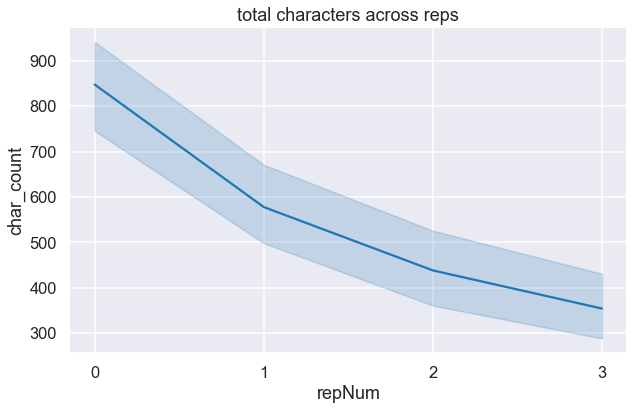

In [10]:
# char count across reps

plt.figure(figsize=(10,6))
sns.lineplot(data=rep_sums, x='repNum',y='char_count')
plt.title('total characters across reps')

### Conventions

### Compositional abstractions

#### Frequency of words over time

#### Emergence of new tokens